# Problem 

We'd like you to work on the following problem:

One of the problems that we face at Govini is mapping entities between disparate data sets. We collect data from a variety of different sources, and knowing that a certain entity is the same from one data set to another is essential.

For example, there may be a company named "FOO" in one data set, and a company named "foo 123" in another. We need to be able to determine with a high enough confidence that those are the same entity. However, a majority of the time, the data does not share a unique key. 

Using the data available, as well as relationships and metadata, we map these together with a high precision. We need you to devise an algorithm that could automatically tie related entities together. The output should have the matches as well as a confidence score for the match.

We are giving you two sample data sets, and it'll be up to you to generate a mapping between the two. In most cases, the mapping should be one to one. An ID from data set A should map to an ID in data set B. 

The sample data sets are available at the following link:
https://s3.amazonaws.com/BUCKET_FOR_FILE_TRANSFER/interview.tar.xz

The archive contains five files, described below:

Procurement Data:

data/mdl__dim_vendor.csv - Company Information
data/mdl__dim_geo.csv - Location Information

mdl__dim_vendor.csv references mdl__dim_geo.csv via the column geo_id.

Finance Data:

data/factset__ent_entity_coverage.csv - Company Information
data/factset__ent_entity_structure.csv - Company Hierarchy
data/factset__ent_entity_address.csv - Location Information

All of these files are tied together using factset_entity_id.

The end goal of this exercise is to explore the data, and map mdl__dim_vendor.vendor_id to corresponding factset__ent_entity_coverage.factset_entity_id. Ideally, a file containing three columns: vendor_id, factset_entity_id, confidence_of_match. Please make sure there is a README file that explains how your algorithm works.

# Simplified Notes

- Problem: Mapping entities between disparate datasets. Collecting data from a veriety of sources, and knowing that a certain entity is the same from one dataset to another is essential.
    - Example: For example, there may be a company named "FOO" in one data set, and a company named "foo 123" in another. We need to be able to determine with a high enough confidence that those are the same entity. However, a majority of the time, the data does not share a unique key.
    
- What Needs To Happen: Need to create an algorithm that could automatically tie related entities together. The output should have the matches as well as a confidence score for the match.

- What I'm Given:
    - Two sample datasets, and it'll be up to you to generate a mapping between the two. In most cases, the mapping should be one to one. An ID from data set A should map to an ID in data set B.
    
- Files Described Below:
    - Procurement Data:

        - data/mdl__dim_vendor.csv - Company Information
        - data/mdl__dim_geo.csv - Location Information
        - mdl__dim_vendor.csv references mdl__dim_geo.csv via the column geo_id.

    - Finance Data:

        - data/factset__ent_entity_coverage.csv - Company Information
        - data/factset__ent_entity_structure.csv - Company Hierarchy
        - data/factset__ent_entity_address.csv - Location Information

**All of these files are tied together using factset_entity_id.**

## End Goal
- Explore the data
- Map **mdl__dim_vendor.vendor_id** to corresponding **factset__ent_entity_coverage.factset_entity_id**
- A file containing three columns: vendor_id, factset_entity_id, confidence_of_match
- README file that explains how your algorithm works

### This seems like an NLP problem

# Steps
1. EDA on data
2. Preprocess data
    - Clean data
    - Make all names lowercase
    - Remove punctuations
3. Vectoriztion
4. Combine datasets a and b with fuzzy name matching

# EDA
- Looking into the data to gain more information

In [1]:
# Importing useful libraries
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt

# Removing unwanted characters
import re
import string

# NLP
"""
fuzzywuzzy package has a module 
called process that allows you to 
calculate the string with the highest 
similarity out of a vector of strings
"""

# Name matching packages
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
# All given datasets
a_company_csv = pd.read_csv("Data/a__company.csv")
a_geo_csv = pd.read_csv("Data/a__geo.csv")
b_address_csv = pd.read_csv("Data/b__address.csv")
b_company_csv = pd.read_csv("Data/b__company.csv")
b_hierarchy = pd.read_csv("Data/b__hierarchy.csv")

/Users/zakijefferson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## a__company.csv

In [3]:
a_company_csv.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,address1,address2,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl
0,26303872,NaN,26303872.0,0,0,100239,"LHASA, LLC [DUNS",NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,16,2018-05-26,0.0
1,144388388,52137010.0,NaN,0,0,52450,"LAKE HAVASU, CITY OF",NaN,NaN,NaN,...,2330 MCCULLOCH BLVD N,NaN,US,86403,NaN,0,0,70,2018-05-26,NaN
2,143446948,NaN,143446948.0,0,0,100239,LONG LEWIS FORD,NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,87,2018-05-26,0.0
3,21723402,NaN,21723402.0,0,0,49677,Lara Jean OConnor,NaN,NaN,NaN,...,6242 Kilmer Loop #204 Arvada,NaN,US,80403,NaN,0,0,9,2018-05-26,0.0
4,151786331,NaN,151786331.0,0,0,100239,LeChris,NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,84,2018-05-26,0.0


In [4]:
# Checking rows and columns of data
a_company_csv.shape

(76344, 23)

In [5]:
# Checking columns
a_company_csv.columns

Index(['vendor_id', 'parent_vendor_id', 'top_vendor_id', 'cnt_children',
       'orgtype_id', 'geo_id', 'name', 'email', 'phone', 'fax', 'dunsnumber',
       'websiteurl', 'address', 'address1', 'address2', 'country', 'zipcode',
       'parentdunsnumber', 'score', 'cnt_opp', 'bucket_id', 'load_date',
       'lvl'],
      dtype='object')

In [6]:
# Looking at missing values
a_company_csv.isna().sum().sum()  # 557,776

557776

In [7]:
a_company_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76344 entries, 0 to 76343
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   vendor_id         76344 non-null  int64  
 1   parent_vendor_id  7957 non-null   float64
 2   top_vendor_id     76312 non-null  float64
 3   cnt_children      76344 non-null  int64  
 4   orgtype_id        76344 non-null  int64  
 5   geo_id            76344 non-null  int64  
 6   name              76344 non-null  object 
 7   email             415 non-null    object 
 8   phone             6655 non-null   object 
 9   fax               0 non-null      float64
 10  dunsnumber        27685 non-null  float64
 11  websiteurl        6622 non-null   object 
 12  address           76344 non-null  object 
 13  address1          53217 non-null  object 
 14  address2          2071 non-null   object 
 15  country           76336 non-null  object 
 16  zipcode           75523 non-null  object

## Graphing Missing Values

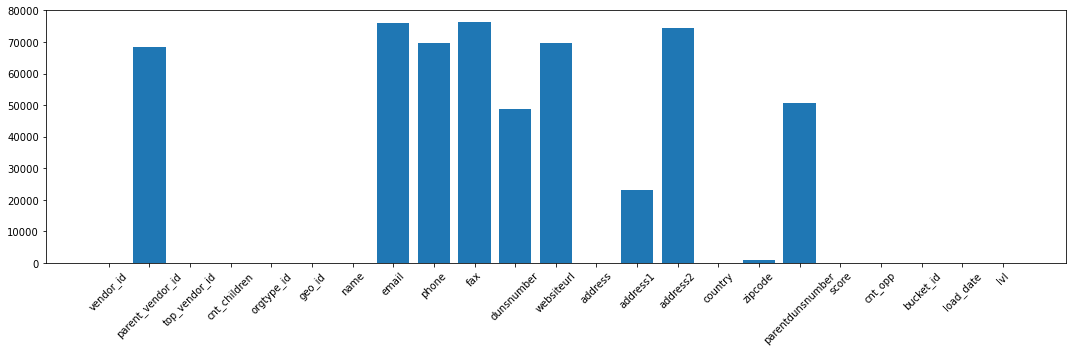

In [8]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = a_company_csv.isna().sum().index  # Retrieving column name with missing values
y = a_company_csv.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

## a__geo.csv

In [9]:
a_geo_csv.head()

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,state_fips,timezone,daylight_saving,region,division,congress_district,congress_land_area,country,continent,country_iso2
0,8278,14467,t,43.043294,-77.614181,513.0,NY,New York,585,HENRIETTA,...,36,5.0,Y,Northeast,Middle Atlantic,25|27,510.19|3973.13,USA,North America,US
1,3430,6258,t,41.8975,-71.9631,287.0,CT,Connecticut,860,POMFRET,...,09,5.0,Y,Northeast,New England,02,1987.68,USA,North America,US
2,48308,78234,t,29.462264,-98.4414,675.0,TX,Texas,210,SAN ANTONIO,...,48,6.0,Y,South,West South Central,21,5920.89,USA,North America,US
3,382713,E2K1K7,t,45.276163,-66.080195,57.0,New Brunswick / Nouveau-Brunswick,New Brunswick / Nouveau-Brunswick,CA-NB,Saint John,...,CA04,NaN,-03:00,NaN,NaN,NaN,NaN,CAN,North America,CA
4,8165,14213,t,42.916747,-78.892782,583.0,NY,New York,716,BUFFALO,...,36,5.0,Y,Northeast,Middle Atlantic,26,219.13,USA,North America,US


In [10]:
a_geo_csv.shape

(14480, 23)

In [11]:
a_geo_csv.columns

Index(['geo_id', 'zipcode', 'is_primary', 'latitude', 'longitude', 'elevation',
       'state', 'state_full_name', 'area_code', 'city', 'city_display',
       'county', 'county_fips', 'state_fips', 'timezone', 'daylight_saving',
       'region', 'division', 'congress_district', 'congress_land_area',
       'country', 'continent', 'country_iso2'],
      dtype='object')

In [12]:
a_geo_csv.isna().sum().sum() # 12,934

12934

## Graphing Missing Values

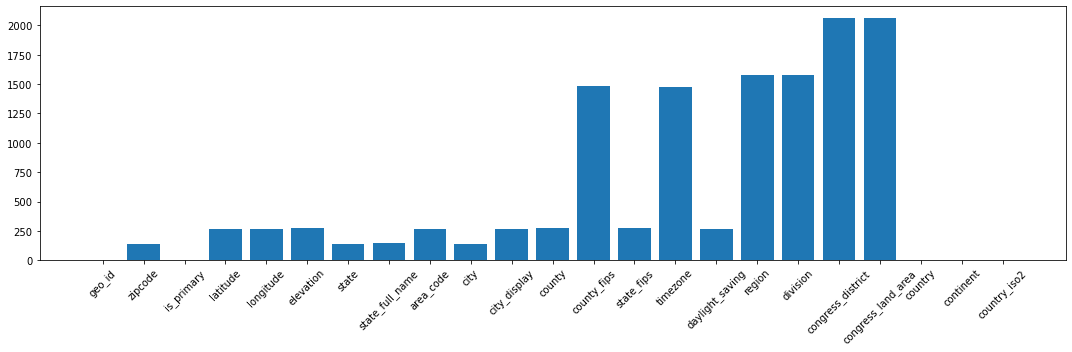

In [13]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = a_geo_csv.isna().sum().index  # Retrieving column name with missing values
y = a_geo_csv.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

## b__address.csv 

In [14]:
b_address_csv.head()

,address_id,b_entity_id,location_city,state_province,location_postal_code,city_state_zip,location_street1,location_street2,location_street3,iso_country,tele_country,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq
0,1000007,0BGRNX-E,Arnhem,GE,6827,"Arnhem, Gelderland 6827",P. Calandweg 54,NaN,NaN,NL,31.0,26,361.16.11,31.26.361.16.11,31.0,26,362.18.91,31.26.362.18.91,1
1,1000203,093RN5-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SE,46.0,NaN,NaN,NaN,46.0,NaN,NaN,NaN,1
2,100029,05PH68-E,Great Milton,LO,NaN,"Great Milton, London & South East",NaN,NaN,NaN,GB,44.0,NaN,NaN,NaN,44.0,NaN,NaN,NaN,1
3,1000307,0BGT26-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AU,61.0,NaN,NaN,NaN,61.0,NaN,NaN,NaN,1
4,1000329,0BGT51-E,Taoyuan,NaN,NaN,Taoyuan,528 Fuhsing 3rd Road,Kueishan Township,NaN,TW,886.0,NaN,NaN,NaN,886.0,NaN,NaN,NaN,1


In [15]:
b_address_csv.shape

(84882, 19)

In [16]:
b_address_csv.columns

Index(['address_id', 'b_entity_id', 'location_city', 'state_province',
       'location_postal_code', 'city_state_zip', 'location_street1',
       'location_street2', 'location_street3', 'iso_country', 'tele_country',
       'tele_area', 'tele', 'tele_full', 'fax_country', 'fax_area', 'fax',
       'fax_full', 'hq'],
      dtype='object')

In [17]:
b_address_csv.isna().sum().sum()  # 488,537

488537

## b__company.csv

In [18]:
b_company_csv.head()

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code
0,000BFG-E,LOTSOFF CORP,LOT$OFF Corp.,5331.0,3520.0,3500.0,US,San Antonio/TX Metro,TX,78209-4859,NaN,PVT,CP,1975.0,US,US,47.19
1,000P08-E,LASERSCOPE INC,"Laserscope, Inc.",3845.0,2325.0,2300.0,US,San Francisco/CA Metro,CA,95134-2011,http://www.laserscope.com,SUB,CP,1982.0,US,IE,26.60
2,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,NaN,PUB,CP,1980.0,US,US,64.99
3,000L15-E,LISI SA,LISI SA,3728.0,1330.0,1300.0,FR,Lyon/France Metro,FC,90000,http://www.lisi-group.com,PUB,CP,1968.0,FR,FR,30.30
4,000NY7-E,LA GEAR INC,"L.A. Gear, Inc.",5139.0,3255.0,3250.0,US,Los Angeles/CA Metro,CA,90049,http://www.lagear.com,SUB,CP,1979.0,US,US,46.42


In [19]:
b_company_csv.shape

(196498, 17)

In [20]:
b_company_csv.columns

Index(['b_entity_id', 'entity_name', 'entity_proper_name', 'primary_sic_code',
       'industry_code', 'sector_code', 'iso_country', 'metro_area',
       'state_province', 'zip_postal_code', 'web_site', 'entity_type',
       'entity_sub_type', 'year_founded', 'iso_country_incorp',
       'iso_country_cor', 'nace_code'],
      dtype='object')

In [21]:
b_company_csv.isna().sum().sum()  # 1,373,134

1373134

## Graphing Missing Values

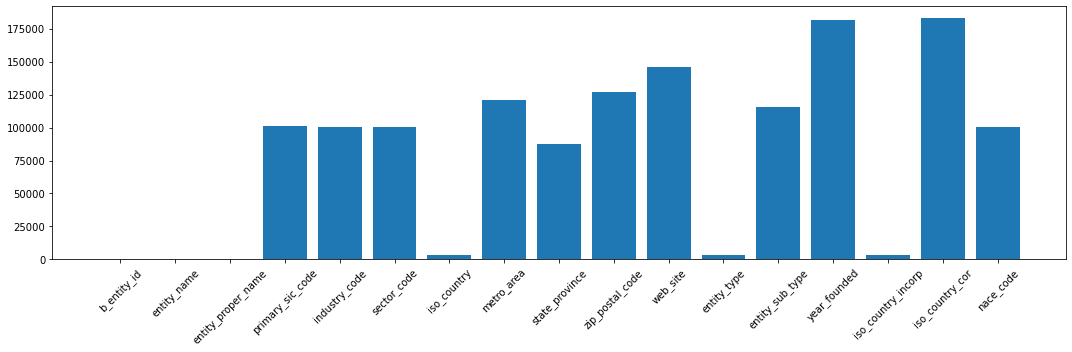

In [22]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = b_company_csv.isna().sum().index  # Retrieving column name with missing values
y = b_company_csv.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

## b__hierarchy.csv

In [23]:
b_hierarchy.head()

,b_entity_id,b_parent_entity_id,b_ultimate_parent_entity_id
0,000BFG-E,NaN,000BFG-E
1,000P08-E,002Y7X-E,00FV7G-E
2,000JP9-E,NaN,000JP9-E
3,000P26-E,NaN,000P26-E
4,000L15-E,05HTCY-E,05HTCY-E


In [24]:
b_hierarchy.shape

(196498, 3)

In [25]:
b_hierarchy.columns

Index(['b_entity_id', 'b_parent_entity_id', 'b_ultimate_parent_entity_id'], dtype='object')

In [26]:
b_hierarchy.isna().sum().sum()  # 128,749

128749

## Graphing Missing Values

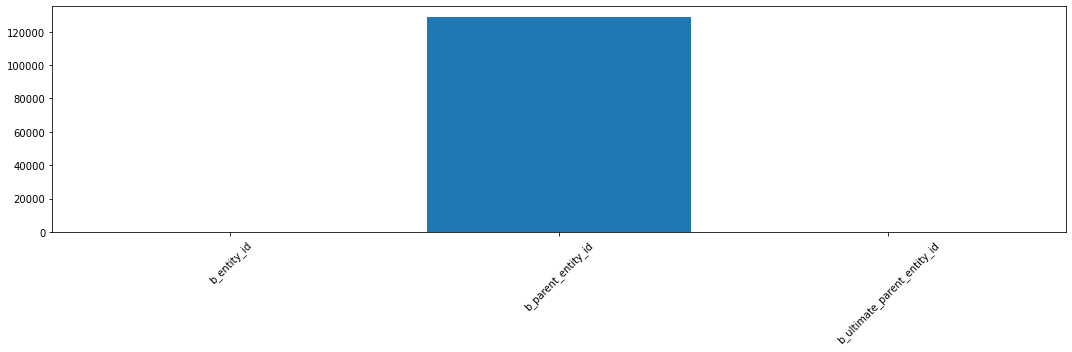

In [27]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = b_hierarchy.isna().sum().index  # Retrieving column name with missing values
y = b_hierarchy.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

## Columns for each dataset

- a__company.csv
'vendor_id', 'parent_vendor_id', 'top_vendor_id', 'cnt_children',
       'orgtype_id', 'geo_id', 'name', 'email', 'phone', 'fax', 'dunsnumber',
       'websiteurl', 'address', 'address1', 'address2', 'country', 'zipcode',
       'parentdunsnumber', 'score', 'cnt_opp', 'bucket_id', 'load_date',
       'lvl'
    
- a__geo.csv
'geo_id', 'zipcode', 'is_primary', 'latitude', 'longitude', 'elevation',
       'state', 'state_full_name', 'area_code', 'city', 'city_display',
       'county', 'county_fips', 'state_fips', 'timezone', 'daylight_saving',
       'region', 'division', 'congress_district', 'congress_land_area',
       'country', 'continent', 'country_iso2'
       
- b__address.csv
'address_id', 'b_entity_id', 'location_city', 'state_province',
       'location_postal_code', 'city_state_zip', 'location_street1',
       'location_street2', 'location_street3', 'iso_country', 'tele_country',
       'tele_area', 'tele', 'tele_full', 'fax_country', 'fax_area', 'fax',
       'fax_full', 'hq'
       
- b__company.csv
'b_entity_id', 'entity_name', 'entity_proper_name', 'primary_sic_code',
       'industry_code', 'sector_code', 'iso_country', 'metro_area',
       'state_province', 'zip_postal_code', 'web_site', 'entity_type',
       'entity_sub_type', 'year_founded', 'iso_country_incorp',
       'iso_country_cor', 'nace_code'
       
- b__hierarchy.csv
'b_entity_id', 'b_parent_entity_id', 'b_ultimate_parent_entity_id'

# Conclusion
- Datasets have a lot of missing values for important information
- All 5 datasets have something in common and will have to be combined into 1 big dataset
- To solve this business problem, NLP will need to be used for Fuzzy Name Matching

## Combining a__company.csv with a__geo.csv

In [28]:
# Merging datasets using geo_id column
a_company_all = pd.merge(a_company_csv, a_geo_csv, on="geo_id", how="inner")

In [29]:
a_company_all.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,state_fips,timezone,daylight_saving,region,division,congress_district,congress_land_area,country_y,continent,country_iso2
0,26303872,NaN,26303872.0,0,0,100239,"LHASA, LLC [DUNS",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
1,143446948,NaN,143446948.0,0,0,100239,LONG LEWIS FORD,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
2,151786331,NaN,151786331.0,0,0,100239,LeChris,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
3,285649634,NaN,285649634.0,0,0,100239,Lisa's Kayaks Inc,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
4,152312291,NaN,152312291.0,0,0,100239,LAURA NUNEZ VILLARTE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US


In [30]:
a_company_all.shape

(76344, 45)

In [31]:
# Looking for any duplicated columns
a_company_all.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [32]:
a_company_all.columns

Index(['vendor_id', 'parent_vendor_id', 'top_vendor_id', 'cnt_children',
       'orgtype_id', 'geo_id', 'name', 'email', 'phone', 'fax', 'dunsnumber',
       'websiteurl', 'address', 'address1', 'address2', 'country_x',
       'zipcode_x', 'parentdunsnumber', 'score', 'cnt_opp', 'bucket_id',
       'load_date', 'lvl', 'zipcode_y', 'is_primary', 'latitude', 'longitude',
       'elevation', 'state', 'state_full_name', 'area_code', 'city',
       'city_display', 'county', 'county_fips', 'state_fips', 'timezone',
       'daylight_saving', 'region', 'division', 'congress_district',
       'congress_land_area', 'country_y', 'continent', 'country_iso2'],
      dtype='object')

## Graphing Missing Values

In [33]:
a_company_all.isna().sum().sum()

1049160

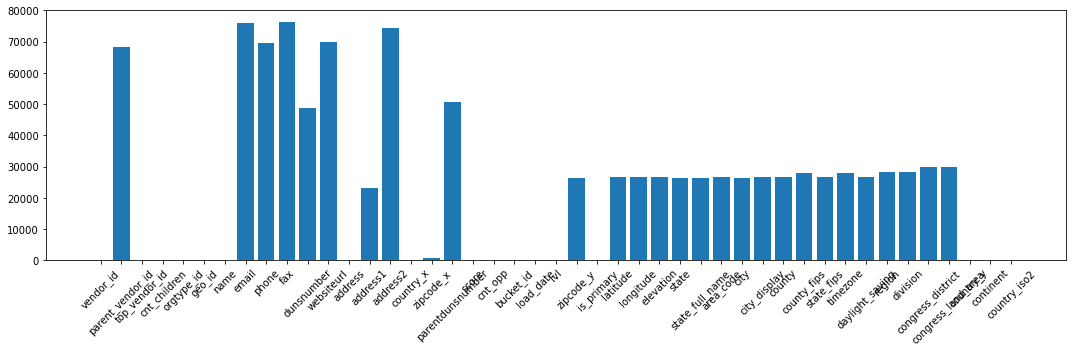

In [34]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = a_company_all.isna().sum().index  # Retrieving column name with missing values
y = a_company_all.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

In [35]:
a_company_all.isna().sum()

vendor_id                 0
parent_vendor_id      68387
top_vendor_id            32
cnt_children              0
orgtype_id                0
geo_id                    0
name                      0
email                 75929
phone                 69689
fax                   76344
dunsnumber            48659
websiteurl            69722
address                   0
address1              23127
address2              74273
country_x                 8
zipcode_x               821
parentdunsnumber      50753
score                     0
cnt_opp                   0
bucket_id                 0
load_date                 0
lvl                      32
zipcode_y             26477
is_primary                0
latitude              26668
longitude             26668
elevation             26677
state                 26477
state_full_name       26484
area_code             26668
city                  26477
city_display          26668
county                26675
county_fips           28036
state_fips          

## Combining b__company.csv, b__address.csv, and b__hierarchy.csv

In [36]:
# Merging b__address.csv and b__hierarchy.csv using b_entity_id column
b_address_hierarchy = pd.merge(b_address_csv, b_hierarchy, on="b_entity_id", how="inner")

In [37]:
# Merging b_address_hierarchy and b_company.csv using b_entity_id
b_company_all = pd.merge(b_company_csv, b_address_hierarchy, on="b_entity_id", how="inner")

In [38]:
b_company_all.head()

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country_x,metro_area,state_province_x,zip_postal_code,...,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq,b_parent_entity_id,b_ultimate_parent_entity_id
0,000BFG-E,LOTSOFF CORP,LOT$OFF Corp.,5331.0,3520.0,3500.0,US,San Antonio/TX Metro,TX,78209-4859,...,210,805.9300,1.210.805.9300,NaN,NaN,NaN,NaN,1,NaN,000BFG-E
1,000P08-E,LASERSCOPE INC,"Laserscope, Inc.",3845.0,2325.0,2300.0,US,San Francisco/CA Metro,CA,95134-2011,...,408,943.0636,1.408.943.0636,1.0,408,943.1051,1.408.943.1051,1,002Y7X-E,00FV7G-E
2,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,818,701.5432,1.818.701.5432,1.0,NaN,NaN,NaN,0,NaN,000JF6-E
3,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,801,209.0740,1.801.209.0740,1.0,801,NaN,NaN,0,NaN,000JF6-E
4,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,480,607.4393,1.480.607.4393,1.0,480,NaN,NaN,1,NaN,000JF6-E


In [39]:
b_company_all.shape

(84882, 37)

## Graphing Missing Values

In [40]:
b_company_all.isna().sum().sum()

917949

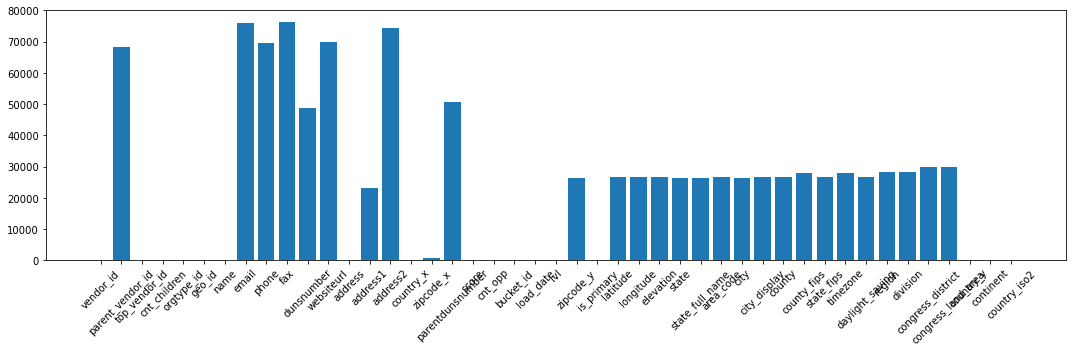

In [41]:
# Creating a bar plot

fig, ax = plt.subplots(figsize=(15, 5))

x = a_company_all.isna().sum().index  # Retrieving column name with missing values
y = a_company_all.isna().sum()  # Number of values missing
ax.bar(x=x, height=y)
ax.set_xticklabels(x, rotation = 45)
plt.tight_layout();

In [42]:
b_company_all.isna().sum()

b_entity_id                        0
entity_name                        0
entity_proper_name                 0
primary_sic_code               33811
industry_code                  33806
sector_code                    33806
iso_country_x                     12
metro_area                     15856
state_province_x               14522
zip_postal_code                16380
web_site                       49098
entity_type                        0
entity_sub_type                    0
year_founded                   66853
iso_country_incorp                12
iso_country_cor                74185
nace_code                      33811
address_id                         0
location_city                   5726
state_province_y               14688
location_postal_code           16630
city_state_zip                  5726
location_street1               12586
location_street2               55033
location_street3               78370
iso_country_y                     12
tele_country                     157
t

## Preprocessing a_company_all

In [43]:
a_company_all.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,state_fips,timezone,daylight_saving,region,division,congress_district,congress_land_area,country_y,continent,country_iso2
0,26303872,NaN,26303872.0,0,0,100239,"LHASA, LLC [DUNS",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
1,143446948,NaN,143446948.0,0,0,100239,LONG LEWIS FORD,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
2,151786331,NaN,151786331.0,0,0,100239,LeChris,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
3,285649634,NaN,285649634.0,0,0,100239,Lisa's Kayaks Inc,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
4,152312291,NaN,152312291.0,0,0,100239,LAURA NUNEZ VILLARTE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US


In [44]:
a_company_all.dtypes

vendor_id               int64
parent_vendor_id      float64
top_vendor_id         float64
cnt_children            int64
orgtype_id              int64
geo_id                  int64
name                   object
email                  object
phone                  object
fax                   float64
dunsnumber            float64
websiteurl             object
address                object
address1               object
address2               object
country_x              object
zipcode_x              object
parentdunsnumber      float64
score                   int64
cnt_opp                 int64
bucket_id               int64
load_date              object
lvl                   float64
zipcode_y              object
is_primary             object
latitude               object
longitude              object
elevation             float64
state                  object
state_full_name        object
area_code              object
city                   object
city_display           object
county    

In [45]:
def clean_text(df, column:str):
    """Make text lowercase, 
    remove square brackers,
    and remove punctuations"""
    df[column] = [names.lower() for names in df[column]]  # Convert all letter to lowercase
    df[column] = [names.encode("ascii", errors="ignore").decode() for names in df[column]] # Remove non ascii chars
    df[column] = [re.sub("\[.*?\]", "", names) for names in df[column]]  # Remove anything in brackets
    df[column] = [re.sub("[%s]" % re.escape(string.punctuation), "", names) for names in df[column]]  # Remove punctuations
    df[column] = [re.sub("\w*\d\w*", "", names) for names in df[column]]  # Remove words with numbers in them
    return df[column]

a_company_all["name"] = clean_text(a_company_all, "name")

In [46]:
a_company_all.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,state_fips,timezone,daylight_saving,region,division,congress_district,congress_land_area,country_y,continent,country_iso2
0,26303872,NaN,26303872.0,0,0,100239,lhasa llc duns,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
1,143446948,NaN,143446948.0,0,0,100239,long lewis ford,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
2,151786331,NaN,151786331.0,0,0,100239,lechris,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
3,285649634,NaN,285649634.0,0,0,100239,lisas kayaks inc,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US
4,152312291,NaN,152312291.0,0,0,100239,laura nunez villarte,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,North America,US


In [47]:
# Separting rows to name and vendor id
a_company_name_id = a_company_all[["vendor_id", "name"]]

In [48]:
a_company_name_id.head()

,vendor_id,name
0,26303872,lhasa llc duns
1,143446948,long lewis ford
2,151786331,lechris
3,285649634,lisas kayaks inc
4,152312291,laura nunez villarte


In [69]:
# Checking for duplicated names
a_company_name_id["name"].duplicated().sum()

12613

In [70]:
# Removing duplicated names
a_company_name_id.drop_duplicates(subset="name", inplace=True)
a_company_name_id["name"].duplicated().sum()

/Users/zakijefferson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [173]:
# Removing business abbreviations
remove_words = ["healthcare", "corporations", "llc", "corp", "parnters", "inc", "co", "corporation", "ltd"]
for i in remove_words:
    a_company_name_id["name"] = a_company_name_id["name"].str.replace(i, "", case = False)

/Users/zakijefferson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Preprocessing b_company_all

In [50]:
b_company_all.head()

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country_x,metro_area,state_province_x,zip_postal_code,...,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq,b_parent_entity_id,b_ultimate_parent_entity_id
0,000BFG-E,LOTSOFF CORP,LOT$OFF Corp.,5331.0,3520.0,3500.0,US,San Antonio/TX Metro,TX,78209-4859,...,210,805.9300,1.210.805.9300,NaN,NaN,NaN,NaN,1,NaN,000BFG-E
1,000P08-E,LASERSCOPE INC,"Laserscope, Inc.",3845.0,2325.0,2300.0,US,San Francisco/CA Metro,CA,95134-2011,...,408,943.0636,1.408.943.0636,1.0,408,943.1051,1.408.943.1051,1,002Y7X-E,00FV7G-E
2,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,818,701.5432,1.818.701.5432,1.0,NaN,NaN,NaN,0,NaN,000JF6-E
3,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,801,209.0740,1.801.209.0740,1.0,801,NaN,NaN,0,NaN,000JF6-E
4,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,480,607.4393,1.480.607.4393,1.0,480,NaN,NaN,1,NaN,000JF6-E


In [51]:
b_company_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84882 entries, 0 to 84881
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   b_entity_id                  84882 non-null  object 
 1   entity_name                  84882 non-null  object 
 2   entity_proper_name           84882 non-null  object 
 3   primary_sic_code             51071 non-null  float64
 4   industry_code                51076 non-null  float64
 5   sector_code                  51076 non-null  float64
 6   iso_country_x                84870 non-null  object 
 7   metro_area                   69026 non-null  object 
 8   state_province_x             70360 non-null  object 
 9   zip_postal_code              68502 non-null  object 
 10  web_site                     35784 non-null  object 
 11  entity_type                  84882 non-null  object 
 12  entity_sub_type              84882 non-null  object 
 13  year_founded    

In [52]:
"""
Using the clean_text
function in order to
clean the text similar to
a_company_all
"""

b_company_all["entity_name"] = clean_text(b_company_all, "entity_name")

In [53]:
b_company_all.head()

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country_x,metro_area,state_province_x,zip_postal_code,...,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq,b_parent_entity_id,b_ultimate_parent_entity_id
0,000BFG-E,lotsoff corp,LOT$OFF Corp.,5331.0,3520.0,3500.0,US,San Antonio/TX Metro,TX,78209-4859,...,210,805.9300,1.210.805.9300,NaN,NaN,NaN,NaN,1,NaN,000BFG-E
1,000P08-E,laserscope inc,"Laserscope, Inc.",3845.0,2325.0,2300.0,US,San Francisco/CA Metro,CA,95134-2011,...,408,943.0636,1.408.943.0636,1.0,408,943.1051,1.408.943.1051,1,002Y7X-E,00FV7G-E
2,000JF6-E,longwen group corp,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,818,701.5432,1.818.701.5432,1.0,NaN,NaN,NaN,0,NaN,000JF6-E
3,000JF6-E,longwen group corp,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,801,209.0740,1.801.209.0740,1.0,801,NaN,NaN,0,NaN,000JF6-E
4,000JF6-E,longwen group corp,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,...,480,607.4393,1.480.607.4393,1.0,480,NaN,NaN,1,NaN,000JF6-E


In [54]:
# Separting rows to name and vendor id
b_company_name_id = b_company_all[["b_entity_id", "entity_name"]]

b_company_name_id.head()

,b_entity_id,entity_name
0,000BFG-E,lotsoff corp
1,000P08-E,laserscope inc
2,000JF6-E,longwen group corp
3,000JF6-E,longwen group corp
4,000JF6-E,longwen group corp


In [71]:
# Checking for duplicated names
b_company_name_id["entity_name"].duplicated().sum()

5066

In [72]:
# Removing duplicated names
b_company_name_id.drop_duplicates(subset="entity_name", inplace=True)
b_company_name_id["entity_name"].duplicated().sum()

/Users/zakijefferson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [73]:
# Removing business abbreviations
remove_words = ["healthcare", "corporations", "llc", "corp", "parnters", "inc", "co", "corporation", "ltd"]
for i in remove_words:
    b_company_name_id['entity_name'] = b_company_name_id['entity_name'].str.replace(i, "", case = False)

/Users/zakijefferson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Fuzzy Name Matching

### Example
- This is a small example of how fuzzywuzzy works

In [74]:
ratio = process.extractBests(a_company_name_id["name"][34], b_company_name_id["entity_name"][:23])

In [75]:
print(a_company_name_id["name"][34])
print("-"*40)
print(b_company_name_id["entity_name"][:23])

lans 
----------------------------------------
0                            lotsoff 
1                           laserspe 
2                      longwen group 
6                             lisi sa
8                            la gear 
9                     la quinta inns 
10              la quinta motor inns 
11                          la z boy 
13                           labarge 
14    laboratory  of america holdings
15                       laclede gas 
16                     laclede steel 
17                 lacrosse footwear 
18                la z boy casegoods 
21             lafarge north america 
22                    lake ariel ban 
23                    lake shore ban 
24                lakeland financial 
25               lakeland industries 
27                      lam research 
28                              lamr 
29                   lamonts apparel 
30                  lamson  sessions 
Name: entity_name, dtype: object


In [76]:
ratio

[('laserspe ', 68, 1),
 ('lakeland financial ', 68, 24),
 ('lakeland industries ', 68, 25),
 ('lamson  sessions ', 68, 30),
 ('lamr ', 50, 28)]

# ---------------------------------------------------------------------------------

## Making datasets smaller

In [116]:
# Removing rows
a_company_name_id_short = a_company_name_id.drop(a_company_name_id.index[600:])

In [117]:
# Only left 200 rows to play with
a_company_name_id_short.shape

(600, 2)

In [118]:
# Removing rows
b_company_name_id_short = b_company_name_id.drop(b_company_name_id.index[600:])

In [119]:
# Only left 200 rows to play with
b_company_name_id_short.shape

(600, 2)

## Creating a series

In [144]:
a_company_name_id_short.head()

,vendor_id,name
0,26303872,lhasa duns
1,143446948,long lewis ford
2,151786331,lechris
3,285649634,lisas kayaks
4,152312291,laura nunez villarte


In [145]:
b_company_name_id_short.head()

,b_entity_id,entity_name
0,000BFG-E,lotsoff
1,000P08-E,laserspe
2,000JF6-E,longwen group
6,000L15-E,lisi sa
8,000NY7-E,la gear


In [148]:
# Creating a series 
compare_names_a_b_series = pd.MultiIndex.from_product([a_company_name_id_short["name"],
                                               b_company_name_id_short["entity_name"]]).to_series()

In [121]:
compare_names_a_b_series.head()

name         entity_name   
lhasa  duns  lotsoff                 (lhasa  duns, lotsoff )
             laserspe               (lhasa  duns, laserspe )
             longwen group     (lhasa  duns, longwen group )
             lisi sa                  (lhasa  duns, lisi sa)
             la gear                 (lhasa  duns, la gear )
dtype: object

## Performing Fuzzy name matching

In [130]:
# Calculates fuzzy metrics and returns a series
def metrics(tup):
    return pd.Series([fuzz.partial_ratio(*tup),  # Uses the length matching to determine a score
                      fuzz.token_set_ratio(*tup),  # Calls ratio on three particular substring sets and returns the max
                      fuzz.token_sort_ratio(*tup)],  # Tokenizes the words and sorts them alphabetically to determine a score
                      ["ratio", "token_set", "token_sort"])

In [131]:
compare_names_a_b_metrics = compare_names_a_b_series.apply(metrics)

In [132]:
compare_names_a_b_metrics

ratio  token_set  token_sort
name        entity_name                                                   
lhasa  duns lotsoff                              38         24          24
            laserspe                             44         33          33
            longwen group                        18         26          26
            lisi sa                              43         47          47
            la gear                              50         35          35
...                                             ...        ...         ...
lisa bonura luna gold                            40         40          40
            lumina foundation for education      55         38          38
            logan capital management             45         23          23
            la jolla ve investors                45         38          38
            linux gold                           36         38          38

[360000 rows x 3 columns]

In [141]:
# Setting a threshold of 92% for the ratio and token
high_score_sort = compare_names_a_b_metrics[(compare_names_a_b_metrics["ratio"] >= 92) &
                                            (compare_names_a_b_metrics["token_set"] >= 92)]


In [142]:
high_score_sort

ratio  \
name                                               entity_name                           
liberty dialysis banksville                        liberty                         100   
liberty intl                                       liberty                         100   
                                                   liberty mint                     92   
lunar systems                                      lunar                           100   
liberty supply mpany dba                           liberty                         100   
lockheed martin  tactical systems                  lockheed martin                 100   
lockheed martin oration missiles and fire ntrol    lockheed martin                 100   
level                                              level one mmunications          100   
                                                   level jump financial group      100   
                                                   level  telem holdings           100   
                                                   level  systems                  100   
louisiana                                          louisiana land  exploration     100   
                                                   louisiana pacific               100   
                                                   louisiana casino cruises        100   
les installations lectriques pichette              les                             100   
lindsay nstruction                                 lindsay                         100   
ld                                                 ld holdings                     100   
les entreprises st louis ltee                      les                             100   
les solutions de rangement prisma                  les                             100   
les architectes goulet et lebel                    les                             100   
ledyard                                            ledyard financial group         100   
les expertises jacques desnoyers   ans             les                             100   
les services dentretiens sld                       les                             100   
les rnovations frangec                             les                             100   
ln holdings                                        lin holdings                     92   
les gestions na carrier                            les                             100   
les encans ritchie bros                            les                             100   
les ateliers kami                                  les                             100   
les entreprises gm laplante lte                    les                             100   
les cimentiers morissette                          les                             100   
les entreprises jacques dufour et fils             les                             100   
les services jfl  qubec                            les                             100   
lockheed martin po box                             lockheed martin                 100   
lauritzen  associates                              lauritzen                       100   
les aliments lbc                                   les                             100   
leidos innovations oration div                     leidos                          100   
lockheed martin global training and logistics      lockheed martin                 100   
lockheed martin oration  dba lockheed martin ae... lockheed martin                 100   
lockheed martin  dba lockheed martin aeronautics   lockheed martin                 100   
lifetime television                                lifetime                        100   
les puits atsiens deschnes                         les                             100   
lsi oration of america                             lsi                             100   
liberty tire auburndale recycling center           liberty                         100   
lockheed martin oration  dba lo

## Using Fuzzy matcher

In [165]:
import fuzzymatcher

In [170]:
# Defining which columns to match for the 2 dataframes
right_a = ["name"]
left_b = ["entity_name"]

matched_results = fuzzymatcher.fuzzy_left_join(df_left=b_company_name_id,
                                               df_right=a_company_name_id,
                                               left_on=left_b, right_on=right_a)

In [186]:
# Organizing dataframe
matched_results = matched_results[["best_match_score", "entity_name", "name", "vendor_id"]]

In [187]:
matched_results.sort_values(by=["best_match_score"], ascending=False, inplace=True)

In [188]:
matched_results.head(20)

,best_match_score,entity_name,name,vendor_id
606107,2.014880,lifeway christian resources of the southern ba...,lifeway christian resources of the southern ba...,49905136.0
833718,1.987137,lenczner slaght royce smith griffin llp,lenczner slaght royce smith griffin llp,310955696.0
1143395,1.973002,lutheran social services of wisnsin upper mic...,lutheran social services of wisnsin upper mic...,20015576.0
3595210,1.921255,lac vieux desert band of lake superior chippew...,lac vieux desert band of lake superior chippew...,136156015.0
1108097,1.851702,legal aid society of middle tennessee the cum...,legal aid society of middle tennessee and the ...,316986498.0
593121,1.846385,lac du flambeau band of lake superior chippewa...,lac du flambeau band of lake superior chippewa...,315431472.0
1095669,1.797841,la jolla institute for allergy immunology,la jolla institute for allergy immunology,23201929.0
3475171,1.781017,lower eastside girls club of new york,lower eastside girls club of new york,24210855.0
751138,1.778050,lucile salter packard childrens hospital at st...,lucile salter packard childrens hospital at st...,148580191.0
3702161,1.776409,lanka jathika sarvodaya shramadana sangamaya,lanka jathika sarvodaya shramadana sangamaya,23768003.0
